<a id="load_the_data"></a>
#  1. Load the data 
> For this notebook, I will only use 'City_time_series.csv' file. I will load the file using pandas read_csv method. And keep the mean of ZHVIPerSqft_AllHomes column at same date. Then I will plot the data. 

In [2]:
# load the data using pandas build in read csv function
df_city_time_series = pd.read_csv('../input/City_time_series.csv',parse_dates=['Date'])
# drop null values in ZHVIPerSqft_AllHomes because we are interested in this column
df_city_time_series = df_city_time_series.dropna(subset=['ZHVIPerSqft_AllHomes'])
# print the head of our data set
df_city_time_series.head()

,Date,RegionName,HomesSoldAsForeclosuresRatio_AllHomes,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,...,ZHVI_BottomTier,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental
1,1996-04-30,aberdeenharfordmd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,81300.0,137900.0,109600.0,108600.0,147900.0,NaN,NaN,NaN,NaN,NaN
3,1996-04-30,aberdeenmoorenc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,87400.0,131000.0,NaN,NaN,NaN,NaN,NaN
5,1996-04-30,abingdonharfordmd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,91000.0,87600.0,123900.0,125600.0,169700.0,NaN,NaN,NaN,NaN,NaN
7,1996-04-30,abingdonwashingtonva,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,89400.0,89400.0,155000.0,NaN,NaN,NaN,NaN,NaN
8,1996-04-30,abingtonmontgomerypa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,102000.0,87800.0,128700.0,130900.0,189400.0,NaN,NaN,NaN,NaN,NaN


In [3]:
df_zhvi_sqft_all = df_city_time_series.set_index('Date').groupby(pd.Grouper(freq='d')).mean().dropna(how='all').ZHVIPerSqft_AllHomes

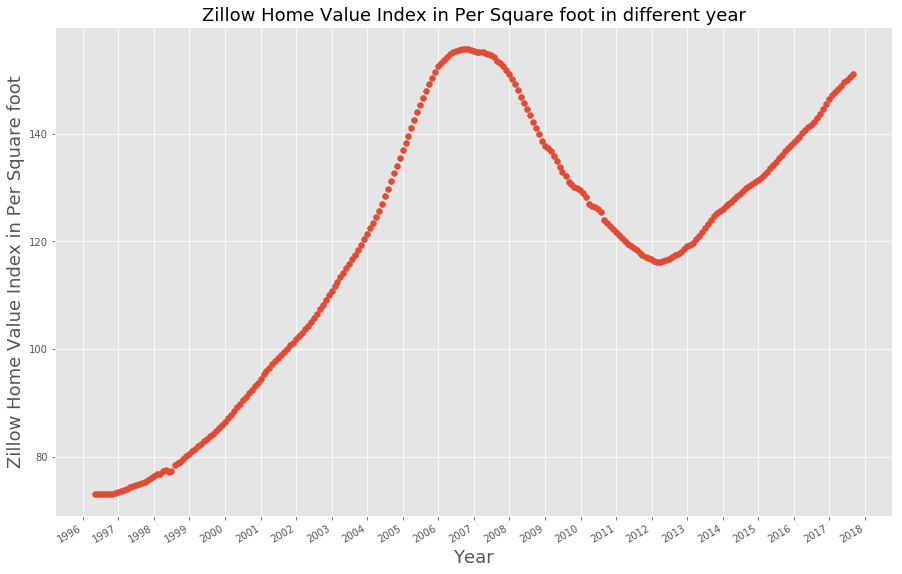

In [4]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_zhvi_sqft_all.index, df_zhvi_sqft_all)
# change x axis year location interval to 1 year. So that it displays data in interval of 1 year
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# Add the title to the graph
plt.title('Zillow Home Value Index in Per Square foot in different year', fontsize=18)
# add xlabel
plt.xlabel('Year', fontsize=18)
# add ylabel
plt.ylabel('Zillow Home Value Index in Per Square foot', fontsize=18)
# beautify the x axis date presentation
fig.autofmt_xdate()
# And finally show the plot in a new window.
plt.show()

# 2. PreProcessing

In [5]:
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [6]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [7]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [8]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [9]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# 3. Training LSTM

In [10]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [11]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size, verbose=0)
	return yhat[0,0]

In [12]:
# convert our column to pandas series 
series = pd.Series(df_zhvi_sqft_all)
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train_size = int(len(supervised_values) * 0.66)
train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [13]:
# repeat 30 times
repeats = 30
# variable for keep track of error scores
error_scores = list()
for r in range(repeats):
    # let's train
    lstm_model = fit_lstm(train_scaled, 1, 30, 4)
    predictions = list()
    # let's predict for test case
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        # report performance
    rmse = sqrt(mean_squared_error(raw_values[train_size:len(supervised_values)], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

1) Test RMSE: 0.531
2) Test RMSE: 0.556
3) Test RMSE: 0.539
4) Test RMSE: 0.530
5) Test RMSE: 0.536
6) Test RMSE: 0.532
7) Test RMSE: 0.532
8) Test RMSE: 0.550
9) Test RMSE: 0.536
10) Test RMSE: 0.542
11) Test RMSE: 0.547
12) Test RMSE: 0.550
13) Test RMSE: 0.548
14) Test RMSE: 0.527
15) Test RMSE: 0.467
16) Test RMSE: 0.543
17) Test RMSE: 0.476
18) Test RMSE: 0.539
19) Test RMSE: 0.516
20) Test RMSE: 0.555
21) Test RMSE: 0.551
22) Test RMSE: 0.543
23) Test RMSE: 0.544
24) Test RMSE: 0.533
25) Test RMSE: 0.492
26) Test RMSE: 0.545
27) Test RMSE: 0.523
28) Test RMSE: 0.528
29) Test RMSE: 0.539
30) Test RMSE: 0.525


In [14]:
# report performance
# summarize results
results = pd.DataFrame()
results['rmse'] = error_scores
# print(results.describe())
# results.boxplot()
# plt.show()

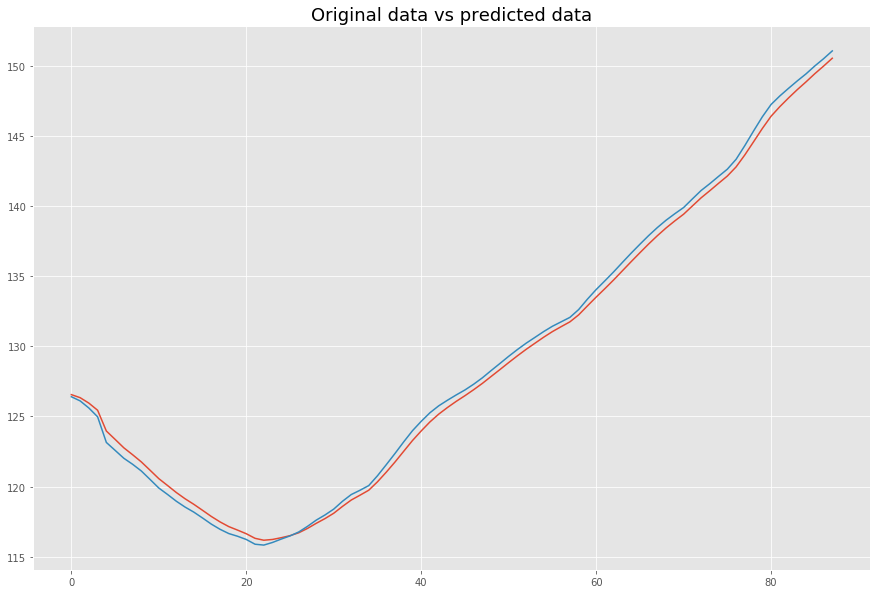

In [15]:
# line plot of observed vs predicted
plt.figure(figsize=(15, 10))
plt.plot(raw_values[train_size:len(supervised_values)])
plt.plot(predictions)
plt.title('Original data vs predicted data', fontsize=18)
plt.show()

In [16]:
# last value of our dataset
f = np.array(151.072060)
# sklearn minmaxscaler for converting "f" to range to (-1,1)
scaler = MinMaxScaler(feature_range=(-1, 1))
# minmaxscaler fit
scaler = scaler.fit(f)
# let's transform
train = f.reshape(1, 1)
train_scaled = scaler.transform(train)

#  4. Price Prediction for Next Years 

In [17]:
# initial record
initial = train_scaled
# store prediction
prediction = []
# range 40 because we want the prediction for next 40 months
for i in range(40):
    # predict 
    yhat = forecast_lstm(lstm_model, 1, initial)
    # inverse prediction to it's original value
    yhat_inver = scaler.inverse_transform(yhat)
    # append to our prediction variable
    prediction.append(yhat_inver)
    # re initial our initial variable so that it feed the current predicted value as input for forecast
    initial = np.array([yhat])

In [18]:
prediction = np.concatenate(prediction, axis=0 ).tolist()
prediction = [item for sublist in prediction for item in sublist]
prediction = pd.DataFrame(prediction)



In [19]:
rng = pd.date_range('2017-08-31 00:00:00', periods=40, freq='M')
rng = pd.DataFrame(rng)
prediction = pd.merge(rng, prediction, left_index=True, right_index=True, how='outer')
prediction.set_index('0_x')
prediction.columns = ['Date', 'ZHVIPerSqft_AllHomes']
prediction

,Date,ZHVIPerSqft_AllHomes
0,2017-08-31,151.473740
1,2017-09-30,151.438675
2,2017-10-31,151.419983
3,2017-11-30,151.403702
4,2017-12-31,151.388611
5,2018-01-31,151.374176
6,2018-02-28,151.360214
7,2018-03-31,151.346741
8,2018-04-30,151.333893
9,2018-05-31,151.321777


In [20]:
original = pd.DataFrame({'Date':df_zhvi_sqft_all.index, 'ZHVIPerSqft_AllHomes':df_zhvi_sqft_all.values})
original

,Date,ZHVIPerSqft_AllHomes
0,1996-04-30,73.161358
1,1996-05-31,73.114557
2,1996-06-30,73.079675
3,1996-07-31,73.083414
4,1996-08-31,73.073895
5,1996-09-30,73.103574
6,1996-10-31,73.165718
7,1996-11-30,73.310458
8,1996-12-31,73.491285
9,1997-01-31,73.731024


In [21]:
frames = [original, prediction]
df_final = pd.concat(frames)
df_final.set_index(['Date'],inplace=True)

In [22]:
df_final = pd.Series(df_final.ZHVIPerSqft_AllHomes)

In [23]:
plt.rc('figure', figsize=(15, 10))


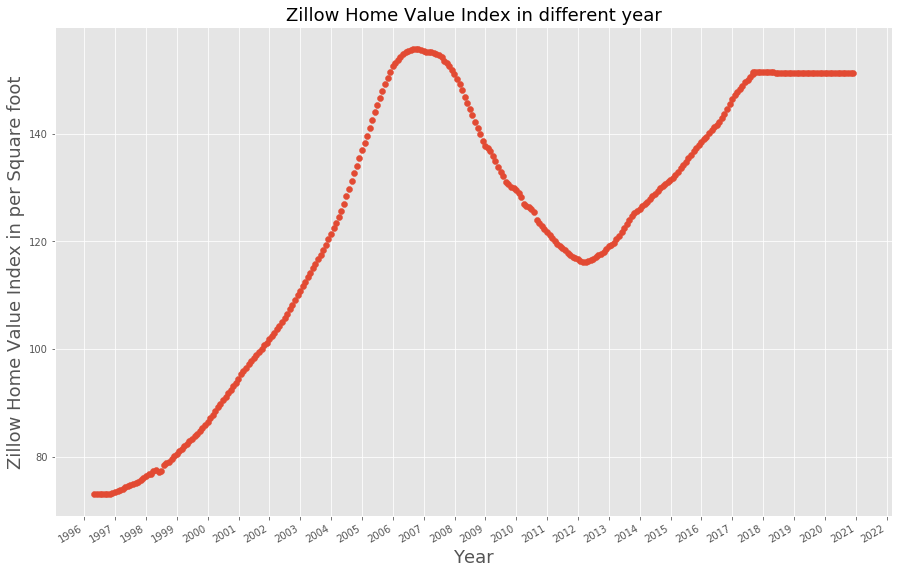

In [24]:
# df_final.plot(figsize=(15, 5),x_compat=True)
fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(df_final.index, df_final)
ax.xaxis.set_major_locator(mdates.YearLocator(1))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.title('Zillow Home Value Index in different year', fontsize=18)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Zillow Home Value Index in per Square foot', fontsize=18)
fig.autofmt_xdate()
plt.show()